Parameter Heatmap
==========

This tutorial will show how to optimize strategies with multiple parameters and how to examine and reason about optimization results.
It is assumed you're already familiar with
[basic _backtesting.py_ usage](https://kernc.github.io/backtesting.py/doc/examples/Quick Start User Guide.html).

First, let's again import our helper moving average function.
In practice, one should use functions from an indicator library, such as
[TA-Lib](https://github.com/mrjbq7/ta-lib) or
[Tulipy](https://tulipindicators.org).

In [1]:
from backtesting.test import SMA

Loading BokehJS ...

Our strategy will be a similar moving average cross-over strategy to the one in
[Quick Start User Guide](https://kernc.github.io/backtesting.py/doc/examples/Quick Start User Guide.html),
but we will use four moving averages in total:
two moving averages whose relationship determines a general trend
(we only trade long when the shorter MA is above the longer one, and vice versa),
and two moving averages whose cross-over with daily _close_ prices determine the signal to enter or exit the position.

In [2]:
from backtesting import Strategy
from backtesting.lib import crossover


class Sma4Cross(Strategy):
    n1 = 50
    n2 = 100
    n_enter = 20
    n_exit = 10
    
    def init(self):
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
        self.sma_enter = self.I(SMA, self.data.Close, self.n_enter)
        self.sma_exit = self.I(SMA, self.data.Close, self.n_exit)
        
    def next(self):
        
        if not self.position:
            
            # On upwards trend, if price closes above
            # "entry" MA, go long
            
            # Here, even though the operands are arrays, this
            # works by implicitly comparing the two last values
            if self.sma1 > self.sma2:
                if crossover(self.data.Close, self.sma_enter):
                    self.buy()
                    
            # On downwards trend, if price closes below
            # "entry" MA, go short
            
            else:
                if crossover(self.sma_enter, self.data.Close):
                    self.sell()
        
        # But if we already hold a position and the price
        # closes back below (above) "exit" MA, close the position
        
        else:
            if (self.position.is_long and
                crossover(self.sma_exit, self.data.Close)
                or
                self.position.is_short and
                crossover(self.data.Close, self.sma_exit)):
                
                self.position.close()

It's not a robust strategy, but we can optimize it.

[Grid search](https://en.wikipedia.org/wiki/Hyperparameter_optimization#Grid_search)
is an exhaustive search through a set of specified sets of values of hyperparameters. One evaluates the performance for each set of parameters and finally selects the combination that performs best.

Let's optimize our strategy on Google stock data using _randomized_ grid search over the parameter space, evaluating at most (approximately) 200 randomly chosen combinations:

In [3]:
%%time 

from backtesting import Backtest
from backtesting.test import GOOG


backtest = Backtest(GOOG, Sma4Cross, commission=.002)

stats, heatmap = backtest.optimize(
    n1=range(10, 110, 10),
    n2=range(20, 210, 20),
    n_enter=range(15, 35, 5),
    n_exit=range(10, 25, 5),
    constraint=lambda p: p.n_exit < p.n_enter < p.n1 < p.n2,
    maximize='Equity Final [$]',
    max_tries=200,
    random_state=0,
    return_heatmap=True)

CPU times: user 322 ms, sys: 42 ms, total: 364 ms
Wall time: 6.27 s


Notice `return_heatmap=True` parameter passed to
[`Backtest.optimize()`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Backtest.optimize).
It makes the function return a heatmap series along with the usual stats of the best run.
`heatmap` is a pandas Series indexed with a MultiIndex, a cartesian product of all permissible (tried) parameter values.
The series values are from the `maximize=` argument we provided.

In [4]:
heatmap

n1   n2   n_enter  n_exit
30   40   15       10       10611.01
          25       20        9006.74
     60   15       10       11297.19
          20       10       11539.78
     80   25       10       11217.25
                              ...   
100  180  20       10       10711.02
     200  25       10        8991.55
                   15        9549.19
                   20        8241.72
          30       15        9701.12
Name: Equity Final [$], Length: 205, dtype: float64

This heatmap contains the results of all the runs,
making it very easy to obtain parameter combinations for e.g. three best runs:

In [5]:
heatmap.sort_values().iloc[-3:]

n1   n2   n_enter  n_exit
40   60   20       15       20019.78
100  120  20       15       20545.03
40   60   25       15       21014.63
Name: Equity Final [$], dtype: float64

But we use vision to make judgements on larger data sets much faster.
Let's plot the whole heatmap by projecting it on two chosen dimensions.
Say we're mostly interested in how parameters `n1` and `n2`, on average, affect the outcome.

In [6]:
hm = heatmap.groupby(['n1', 'n2']).mean().unstack()
hm

n2,40,60,80,100,120,140,160,180,200
n1,,,,,,,,,
30,9808.88,11418.49,12183.57,10970.01,9823.28,10634.02,12761.29,11129.58,10818.95
40,nan,15237.61,11123.54,8036.80,12899.93,12606.21,12108.13,nan,9707.38
50,nan,6614.39,10249.40,10759.11,10741.92,11369.56,10508.96,11118.57,10282.21
60,nan,nan,6949.90,11278.54,9855.09,11674.47,12361.64,9277.57,9520.61
70,nan,nan,13241.52,8630.84,9447.04,9647.08,10854.71,9298.65,8120.51
80,nan,nan,nan,8312.86,9165.66,10169.51,11992.31,10748.77,nan
90,nan,nan,nan,11454.72,12570.32,10656.17,12041.58,10927.90,9396.30
100,nan,nan,nan,nan,12372.87,10093.88,11733.34,10711.02,9120.90


Let's plot this table using the excellent [_Seaborn_](https://seaborn.pydata.org) package:

<AxesSubplot:xlabel='n2', ylabel='n1'>

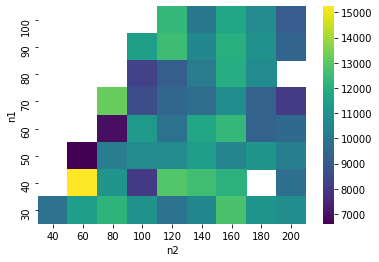

In [7]:
%matplotlib inline

import seaborn as sns


sns.heatmap(hm[::-1], cmap='viridis')

We see that, on average, we obtain the highest result using trend-determining parameters `n1=40` and `n2=60`,
and it's not like other nearby combinations work similarly well — in our particular strategy, this combination really stands out.

Since our strategy contains several parameters, we might be interested in other relationships between their values.
We can use
[`backtesting.lib.plot_heatmaps()`](https://kernc.github.io/backtesting.py/doc/backtesting/lib.html#backtesting.lib.plot_heatmaps)
function to plot interactive heatmaps of all parameter combinations simultaneously.

In [8]:
from backtesting.lib import plot_heatmaps


plot_heatmaps(heatmap, agg='mean')

Column(id='1252', ...)

## Model-based optimization

Above, we used _randomized grid search_ optimization method. Any kind of grid search, however, might be computationally expensive for large data sets. In the follwing example, we will use
[_scikit-optimize_](https://scikit-optimize.github.io)
package to guide our optimization better informed using forests of decision trees.
The hyperparameter model is sequentially improved by evaluating the expensive function (the backtest) at the next best point, thereby hopefully converging to a set of optimal parameters with as few evaluations as possible.

So, with `method="skopt"`:

In [9]:
%%capture

! pip install scikit-optimize  # This is a run-time dependency

In [10]:
%%time

stats_skopt, heatmap, optimize_result = backtest.optimize(
    n1=[10, 100],      # Note: For method="skopt", we
    n2=[20, 200],      # only need interval end-points
    n_enter=[10, 40],
    n_exit=[10, 30],
    constraint=lambda p: p.n_exit < p.n_enter < p.n1 < p.n2,
    maximize='Equity Final [$]',
    method='skopt',
    max_tries=200,
    random_state=0,
    return_heatmap=True,
    return_optimization=True)

CPU times: user 24.3 s, sys: 50.4 ms, total: 24.4 s
Wall time: 24.4 s


In [11]:
heatmap.sort_values().iloc[-3:]

n1  n2   n_enter  n_exit
68  96   29       24       28424.02
35  98   28       24       28658.80
44  134  39       27       30251.81
Name: Equity Final [$], dtype: float64

Notice how the optimization runs somewhat slower even though `max_tries=` is the same. But that's due to the sequential nature of the algorithm and should actually perform rather comparably even in cases of _much larger parameter spaces_ where grid search would effectively blow up, but likely (hopefully) reaching a better local optimum than a randomized search would.
A note of warning, again, to take steps to avoid
[overfitting](https://en.wikipedia.org/wiki/Overfitting)
insofar as possible.

Understanding the impact of each parameter on the computed objective function is easy in two dimensions, but as the number of dimensions grows, partial dependency plots are increasingly useful.
[Plotting tools from _scikit-optimize_](https://scikit-optimize.github.io/stable/modules/plots.html)
take care of many of the more mundane things needed to make good and informative plots of the parameter space:

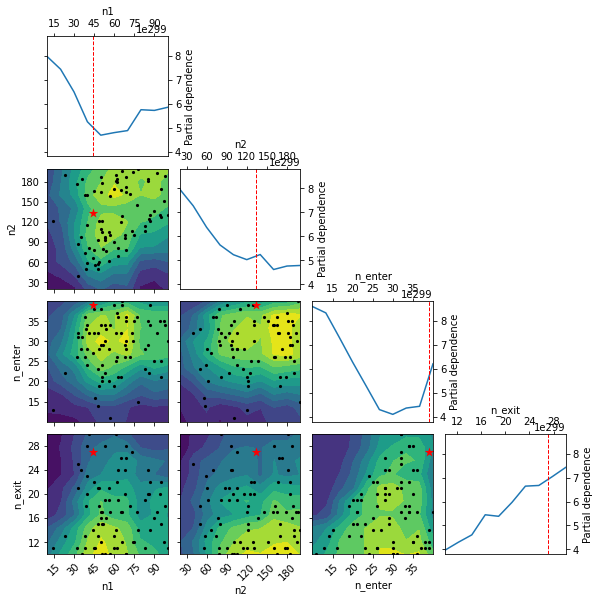

In [12]:
from skopt.plots import plot_objective

_ = plot_objective(optimize_result, n_points=10)

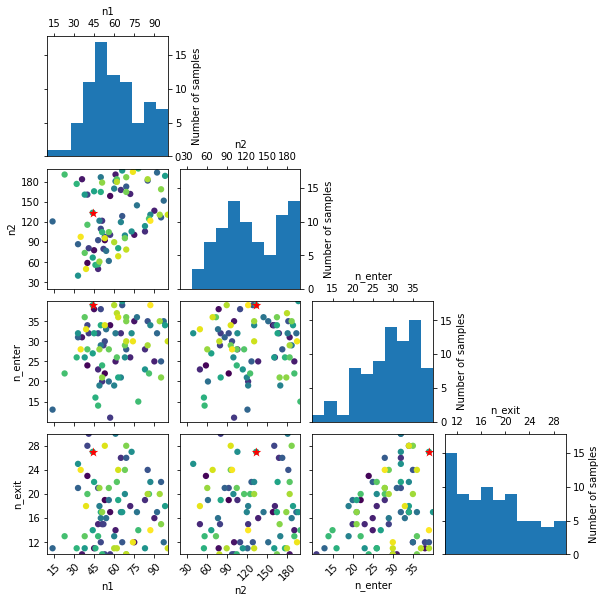

In [13]:
from skopt.plots import plot_evaluations

_ = plot_evaluations(optimize_result, bins=10)

Learn more by exploring further
[examples](https://kernc.github.io/backtesting.py/doc/backtesting/index.html#tutorials)
or find more framework options in the
[full API reference](https://kernc.github.io/backtesting.py/doc/backtesting/index.html#header-submodules).